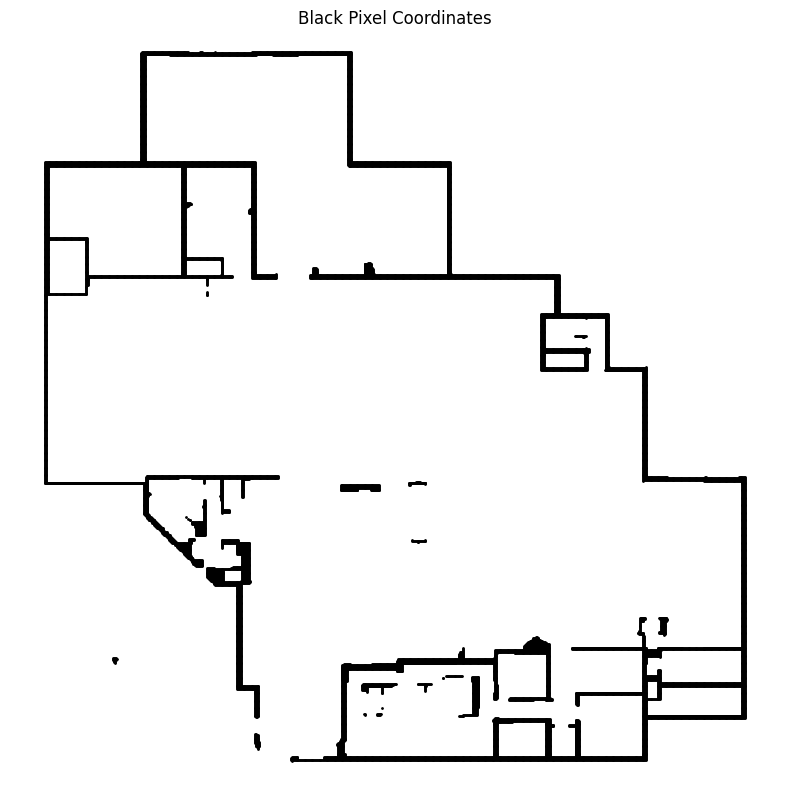

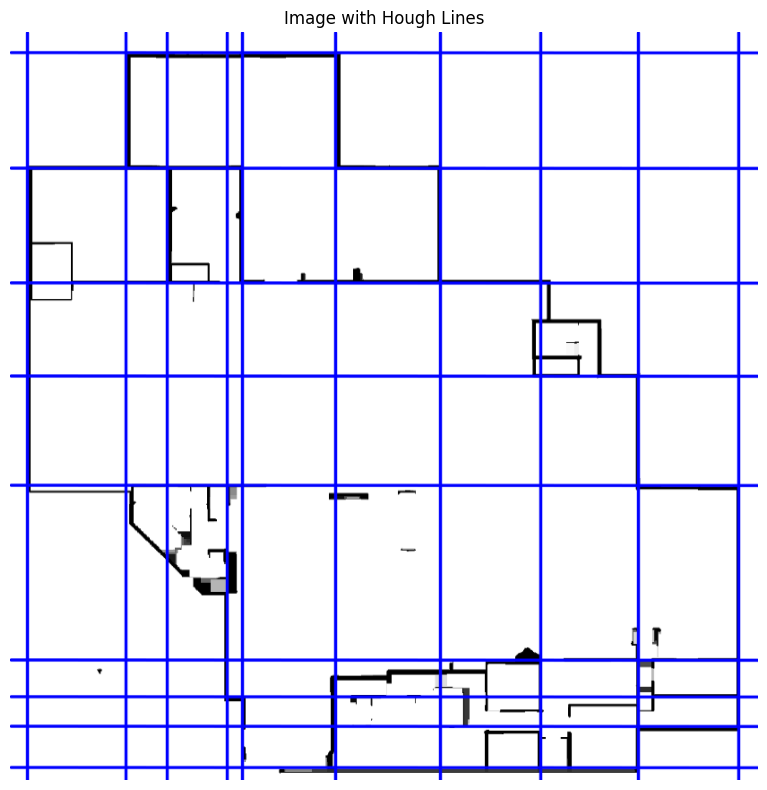

Accuracy of Hough lines fitting: 41.70%


In [36]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def distance_point_to_line(point, line):
    """Calculate the distance from a point to a line given in rho, theta format."""
    rho, theta = line
    x, y = point
    return abs(x * np.cos(theta) + y * np.sin(theta) - rho)

def evaluate_hough_lines(black_pixels, hough_lines, threshold=5):
    """Evaluate how well the Hough lines fit the black pixels with an accuracy percentage."""
    close_points = 0
    total_points = len(black_pixels)
    for point in black_pixels:
        distances = [distance_point_to_line(point, line) for line in hough_lines]
        min_distance = min(distances)
        if min_distance <= threshold:
            close_points += 1
    accuracy_percentage = (close_points / total_points) * 100 if total_points > 0 else 0
    return accuracy_percentage

# Read the image
filename = 'img/reassembled_SE2.png'
src = cv.imread(filename, cv.IMREAD_GRAYSCALE)
if src is None:
    print('Error opening image!')
    print('Usage: hough_lines.py [image_name] \n')
    exit()

# Resize the image to make it square
max_dim = max(src.shape[:2])
src_square = cv.resize(src, (max_dim, max_dim), interpolation=cv.INTER_LINEAR)

# Apply morphological opening
kernel = np.ones((5, 5), np.uint8)
src_square = cv.morphologyEx(src_square, cv.MORPH_OPEN, kernel, iterations=3)

# Threshold the image to create a binary image
_, binary = cv.threshold(src_square, 127, 255, cv.THRESH_BINARY_INV)

# Find the coordinates of the black pixels
black_pixels = np.argwhere(binary == 255)

# Extract x and y coordinates and flip y-coordinates
x_coords = black_pixels[:, 1]
y_coords = max_dim - black_pixels[:, 0]  # Flip the y-coordinates

# Plot the coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, s=1, color='black')
plt.axis('equal')
plt.axis('off')
plt.title('Black Pixel Coordinates')
plt.tight_layout()
plt.show()

# Edge detection
dst = cv.Canny(src_square, 50, 200, None, 3)

# Hough transform with non-maximum suppression
lines = cv.HoughLines(dst, 0.1, np.pi / 180, max_dim//10, None, 0, 0)
all_lines = []
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        max_len = int(np.sqrt(2) * max_dim)
        pt1 = (int(x0 + max_len*(-b)), int(y0 + max_len*(a)))
        pt2 = (int(x0 - max_len*(-b)), int(y0 - max_len*(a)))
        all_lines.append((pt1, pt2, theta))

strong_lines = np.zeros([len(all_lines),1,2])
n2 = 0
for n1 in range(0, len(all_lines)):
    pt1, pt2, theta = all_lines[n1]
    rho = abs((pt2[1] - pt1[1]) * pt1[0] - (pt2[0] - pt1[0]) * pt1[1]) / np.sqrt((pt2[1] - pt1[1])**2 + (pt2[0] - pt1[0])**2)
    if n1 == 0:
        strong_lines[n2] = [[rho, theta]]
        n2 = n2 + 1
    else:
        if rho < 0:
            rho *= -1
            theta -= np.pi
        closeness_rho = np.isclose(rho, strong_lines[0:n2,0,0], atol=10)  # Decrease atol for rho
        closeness_theta = np.isclose(theta, strong_lines[0:n2,0,1], atol=np.pi/45)  # Decrease atol for theta
        closeness = np.all([closeness_rho, closeness_theta], axis=0)
        if not any(closeness):
            strong_lines[n2] = [[rho, theta]]
            n2 = n2 + 1

# Create a color copy of the image
src_square_color = cv.cvtColor(src_square, cv.COLOR_GRAY2BGR)

# Draw Hough lines on the color image
for line in strong_lines[:n2]:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    max_len = int(np.sqrt(2) * max_dim)
    pt1 = (int(x0 + max_len*(-b)), int(y0 + max_len*(a)))
    pt2 = (int(x0 - max_len*(-b)), int(y0 - max_len*(a)))
    cv.line(src_square_color, pt1, pt2, (255, 0, 0), 2, cv.LINE_AA)

# Display the image with Hough lines
plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(src_square_color, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Image with Hough Lines')
plt.tight_layout()
plt.show()

# Evaluate the accuracy of Hough lines
if n2 > 0:
    hough_lines = [(line[0][0], line[0][1]) for line in strong_lines[:n2]]
    accuracy = evaluate_hough_lines(list(zip(x_coords, y_coords)), hough_lines)
    print(f"Accuracy of Hough lines fitting: {accuracy:.2f}%")
else:
    print("No Hough lines detected.")